In [1]:
import torch
import torch.nn as nn
import torch.autograd as grad

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.

    This is according to the reverse mode autodiff rule,

    sum_i v^b_i dy^b_i / dx^b_j = sum_i x^b_j R_ji v^b_i,

    where:
    - b is the batch index from 0 to B - 1
    - i, j are the vector indices from 0 to N-1
    - v^b_i is a "test vector", which is set to 1 column-wise to obtain the correct
        column vectors out ot the above expression.

    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """

    B, N = x.shape
    y, _ = f(x)
    # y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = torch.autograd.grad(y,
                       x,
                       grad_outputs=v,
                       retain_graph=True,
                       create_graph=True,
                       allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)

    jacobian = torch.stack(jacobian, dim=2).requires_grad_()

    return jacobian

In [2]:
import torch
import torch.nn as nn
import torch.autograd as grad
import math
from flows import *

In [57]:
net = DenseTriangularFlow(2, False)
net.w = nn.Parameter(torch.tensor([[1.5, 0.0], [2.5, 0.5]]))
net.b = nn.Parameter(torch.tensor([1.0, -1.0]))
x = torch.tensor([[1.0, 2.0]])
x.requires_grad = True

print(jacobian(net, x))
print(jacobian(net, x)[0].diag().log().sum())

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

tensor([[[1.5000, 2.5000],
         [0.0000, 0.5000]]], grad_fn=<StackBackward>)
tensor(-0.2877, grad_fn=<SumBackward0>)
tensor([[2.5000, 2.5000]], grad_fn=<AddBackward0>) tensor(-0.2877, grad_fn=<SumBackward0>)
tensor([[1., 2.]], grad_fn=<SqueezeBackward1>) tensor(0.2877, grad_fn=<MulBackward0>)


In [59]:
net = SigmoidFlow()
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
x.requires_grad = True

print(jacobian(net, x))
print(jacobian(net, x)[0].diag().log().sum())

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

tensor([[[0.1966, 0.0000],
         [0.0000, 0.1050]],

        [[0.0452, 0.0000],
         [0.0000, 0.0177]]], grad_fn=<StackBackward>)
tensor(-3.8804, grad_fn=<SumBackward0>)
tensor([[0.7311, 0.8808],
        [0.9526, 0.9820]], grad_fn=<SigmoidBackward>) tensor([-3.8804, -7.1335], grad_fn=<SumBackward1>)
tensor([[1.0000, 2.0000],
        [3.0000, 4.0000]], grad_fn=<LogBackward>) tensor([3.8804, 7.1335], grad_fn=<NegBackward>)


In [61]:
net = InverseFlow(SigmoidFlow())
x = torch.tensor([[0.7311, 0.8808], [0.9526, 0.9820]])
x.requires_grad = True

print(jacobian(net, x))
print(jacobian(net, x)[0].diag().log().sum())

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

tensor([[[ 5.0867,  0.0000],
         [ 0.0000,  9.5246]],

        [[22.1468,  0.0000],
         [ 0.0000, 56.5739]]], grad_fn=<StackBackward>)
tensor(3.8805, grad_fn=<SumBackward0>)
tensor([[1.0002, 2.0000],
        [3.0006, 3.9992]], grad_fn=<LogBackward>) tensor([3.8805, 7.1332], grad_fn=<NegBackward>)
tensor([[0.7311, 0.8808],
        [0.9526, 0.9820]], grad_fn=<SigmoidBackward>) tensor([-3.8805, -7.1332], grad_fn=<SumBackward1>)


In [12]:
net = SoftlogFlow()
x = torch.tensor([[-1.0, -0.01, 0.0, 0.01, 2.0]])
x.requires_grad = True

print(jacobian(net, x))
print(jacobian(net, x)[0].diag().log().sum())

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

tensor([[[0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.9901, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.9901, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.3333]]], grad_fn=<StackBackward>)
tensor(-1.8117, grad_fn=<SumBackward0>)
tensor([[-0.6931, -0.0100,  0.0000,  0.0100,  1.0986]],
       grad_fn=<SoftlogFlowFunctionBackward>) tensor([-1.8117], grad_fn=<SumBackward1>)
tensor([[-1.0000, -0.0100,  0.0000,  0.0100,  2.0000]], grad_fn=<MulBackward0>) tensor([1.8117], grad_fn=<NegBackward>)


In [3]:
from flows import *
net = SoftsquareFlow()
x = torch.tensor([[-2.0, -1.0, 0.0, 1.0, 2.0]])
x.requires_grad = True

print(jacobian(net, x))
print(jacobian(net, x)[0].diag().log().sum())

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

TypeError: __init__() missing 1 required positional argument: 'dim'

In [5]:
from flows import *
import numpy

net = RankOneConvolutionFlow(2, epsilon=0.0)
# net.vT = torch.nn.Parameter(torch.tensor([[4.0, 0.25]]))
# net.u = torch.nn.Parameter(torch.tensor([[0.5], [2.0]]))
x = torch.tensor([[-1.0, 0.0], [1.0, 2.0]])
x.requires_grad = True

print(jacobian(net, x))
print(math.log(numpy.linalg.det(jacobian(net, x)[0].detach().numpy())))

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

tensor([[[1., 0.],
         [0., 1.]],

        [[1., 0.],
         [0., 1.]]], grad_fn=<StackBackward>)
0.0
tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<AddBackward0>) tensor(0., grad_fn=<LogBackward>)
tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>) tensor([[0.]], grad_fn=<LogBackward>)


In [2]:
from flows import *
import numpy

net = RankOneConvolutionFlow(2, epsilon=0.0)
net.vT = torch.nn.Parameter(torch.tensor([[-1.0497, -0.4827]]))
net.u = torch.nn.Parameter(torch.tensor([[-1.0532], [0.2746]]))
x = torch.tensor([[-1.0, 0.0], [1.0, 2.0]])
x.requires_grad = True

print(jacobian(net, x))
print(math.log(numpy.linalg.det(jacobian(net, x)[0].detach().numpy())))

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

TypeError: __init__() got an unexpected keyword argument 'epsilon'

In [ ]:
tensor([[[2., 1.],
         [1., 2.]],

        [[2., 1.],
         [1., 2.]]], requires_grad=True)
1.0986122886681098
tensor([[-2., -1.],
        [ 4.,  5.]], grad_fn=<AddBackward0>) tensor(1.0986)
tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>) tensor([[-1.0986]])

In [2]:
net = NormalCdfFlow()
x = torch.tensor([[-1.0, -0.01, 0.0, 0.01, 1.0]])
x.requires_grad = True

print(jacobian(net, x))
print(jacobian(net, x)[0].diag().log().sum())

y, log_det = net(x)
print(y, log_det)
x, log_det_x = net.backward(y)
print(x, log_det_x)

NameError: name 'NormalCdfFlow' is not defined

In [4]:
net = NegLogLikelihoodLoss(2)
x = torch.tensor([[0.0, 0.], [0.3, 1.4]])
net(x, torch.tensor(2.0))

tensor(0.3504)

In [2]:
net = FlowModule(
    InverseFlow(NormalCdfFlow()),
    NegLogLikelihoodLoss(2)
)
x = torch.tensor([[0.0, 0.1], [0.1, 0.2], [0.9, 1.0]])
net(x)

tensor([   inf, 2.3507,    inf])


tensor(nan)

In [5]:
net = NegLogLikelihoodLoss(2)
dist = MultivariateNormal(torch.zeros(dim), torch.eye(dim))

x = torch.tensor([[0.0, 0.], [0.3, 1.4]])

print(net.forward(x))
print(dist.log_prob(x))

NameError: name 'MultivariateNormal' is not defined

In [22]:
import numpy as np

tri = DenseTriangularFlow(3, True)
triu = DenseTriangularFlow(3, False)
sig = SigmoidFlow()
net = Flows(tri, triu, sig)

x = torch.tensor([[1.0, 2.0, 3.0]])
x.requires_grad = True

print(net(x))
print(jacobian(net, x))
print(math.log(np.linalg.det(jacobian(net, x)[0].detach().numpy())))

(tensor([[0.7311, 0.8808, 0.9526]], grad_fn=<SigmoidBackward>), tensor([-6.9776], grad_fn=<AddBackward0>))
tensor([[[0.1966, 0.0000, 0.0000],
         [0.0000, 0.1050, 0.0000],
         [0.0000, 0.0000, 0.0452]]], grad_fn=<StackBackward>)
-6.97755383437876


In [76]:
normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

x = torch.tensor([[0.2, 0.3], [0.5, 0.6], [0.7, 0.8]])
x.requires_grad = True

print(jacobian(normal.icdf, x))

ValueError: too many values to unpack (expected 2)

In [77]:
import pandas
import torch.utils.data
table = torch.tensor(pandas.read_csv("./data/dark-spectrum.csv").values, dtype=torch.float32)
print(table)
dataset = torch.utils.data.TensorDataset(table)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)

tensor([[-2.2066, -1.4045, -1.0019],
        [-1.4313, -1.7853, -1.8912],
        [-0.3032, -0.4076,  0.2221],
        ...,
        [-2.8856, -2.8856, -2.3352],
        [-0.5054, -1.1992, -1.3539],
        [-1.9533, -1.6189, -1.3788]])


In [89]:
dim = 3
cdf_flows = Flows(
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SoftlogFlow(),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    DenseTriangularFlow(dim, True),
    DenseTriangularFlow(dim, False),
    SigmoidFlow()
)

flows = Flows(
    cdf_flows,
    InverseFlow(NormalCdfFlow())
)
net = FlowModule(flows, NegLogLikelihoodLoss(dim))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

print(list(net.parameters()))

[Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True), Parameter containin

In [90]:
final_loss = 0.0
nan_data = torch.tensor([])
for batch in range(40):  #1oop over the dataset multiple times
    for _, data in enumerate(dataloader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = net(data[0])
        if loss != loss:
            nan_data = data
            print("Nan found during training.  Aborting")
            break
        
        loss.backward()
        optimizer.step()
        final_loss = loss
print("final loss: %.03f" % final_loss)

_fn=<MulBackward0>)
tensor(2.9074, grad_fn=<MulBackward0>)
tensor(2.8572, grad_fn=<MulBackward0>)
tensor(2.6795, grad_fn=<MulBackward0>)
tensor(2.8443, grad_fn=<MulBackward0>)
tensor(2.8405, grad_fn=<MulBackward0>)
tensor(2.8147, grad_fn=<MulBackward0>)
tensor(2.9359, grad_fn=<MulBackward0>)
tensor(2.8664, grad_fn=<MulBackward0>)
tensor(2.9215, grad_fn=<MulBackward0>)
tensor(2.9567, grad_fn=<MulBackward0>)
tensor(2.9510, grad_fn=<MulBackward0>)
tensor(2.8814, grad_fn=<MulBackward0>)
tensor(2.8120, grad_fn=<MulBackward0>)
tensor(2.7669, grad_fn=<MulBackward0>)
tensor(2.9271, grad_fn=<MulBackward0>)
tensor(2.9712, grad_fn=<MulBackward0>)
tensor(2.7929, grad_fn=<MulBackward0>)
tensor(2.9131, grad_fn=<MulBackward0>)
tensor(2.9032, grad_fn=<MulBackward0>)
tensor(2.9290, grad_fn=<MulBackward0>)
tensor(2.9144, grad_fn=<MulBackward0>)
tensor(2.8541, grad_fn=<MulBackward0>)
tensor(2.6942, grad_fn=<MulBackward0>)
tensor(2.8436, grad_fn=<MulBackward0>)
tensor(2.8405, grad_fn=<MulBackward0>)
tenso

In [121]:
print(nan_data)
cdf_data, log_det = cdf_flows.forward(nan_data[0])
print(cdf_data.max(0)[1])
print(nan_data[0][605])
vtrace, det_trace = cdf_flows.forward_trace(nan_data[0][605].unsqueeze(0))
for v in vtrace:
    print(v)

[tensor([[-2.2066, -1.4045, -1.0019],
        [-1.4313, -1.7853, -1.8912],
        [-0.3032, -0.4076,  0.2221],
        ...,
        [-2.8856, -1.9533, -1.3064],
        [ 0.8514, -1.3539, -1.3064],
        [-2.8856, -2.8856, -2.8856]])]
tensor([605, 150, 605])
tensor([-1.3064, -2.8856, -1.5836])
tensor([[-0.0578, -2.3388, -1.4740]], grad_fn=<AddBackward0>)
tensor([[ 0.5338, -1.5157,  0.3827]], grad_fn=<AddBackward0>)
tensor([[ 0.8351, -1.0000,  0.8488]], grad_fn=<AddBackward0>)
tensor([[ 2.1552, -0.5221,  1.9303]], grad_fn=<AddBackward0>)
tensor([[ 1.1491, -0.4201,  1.0751]], grad_fn=<SoftlogFlowFunctionBackward>)
tensor([[ 2.1816, -0.3896,  1.9050]], grad_fn=<AddBackward0>)
tensor([[ 3.1153, -1.0572,  4.2895]], grad_fn=<AddBackward0>)
tensor([[ 9.3266, -0.0236,  5.6353]], grad_fn=<AddBackward0>)
tensor([[16.6831, -3.2511,  3.7007]], grad_fn=<AddBackward0>)
tensor([[1.0000, 0.0373, 0.9759]], grad_fn=<SigmoidBackward>)


In [31]:
import pandas

outputs = torch.rand(100, 3)
inputs, log_det = cdf_flows.backward(outputs)
pandas.DataFrame(inputs.detach().numpy()).to_csv('data/dark-spectrum-output.csv', header=False, index=False)

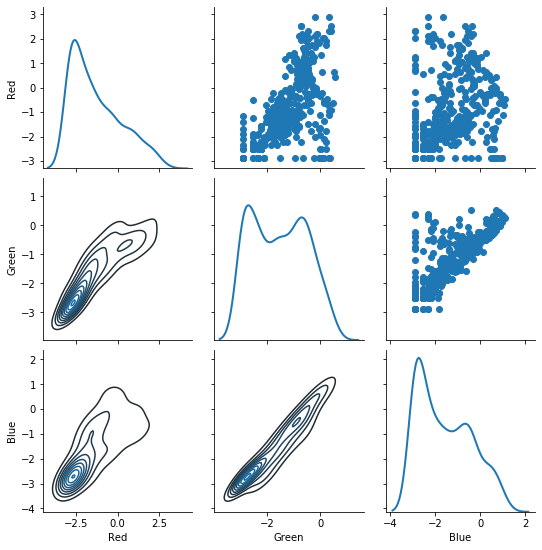

In [50]:
import numpy
import seaborn
import matplotlib.pylab
import pandas
cols = ['Red', 'Green', 'Blue']
data = pandas.DataFrame(table[0:500].numpy(), columns = cols)
g = seaborn.PairGrid(data)
g.map_upper(matplotlib.pylab.scatter)
g.map_diag(seaborn.kdeplot, lw=2, legend=False);
g.map_lower(seaborn.kdeplot)
matplotlib.pylab.show()

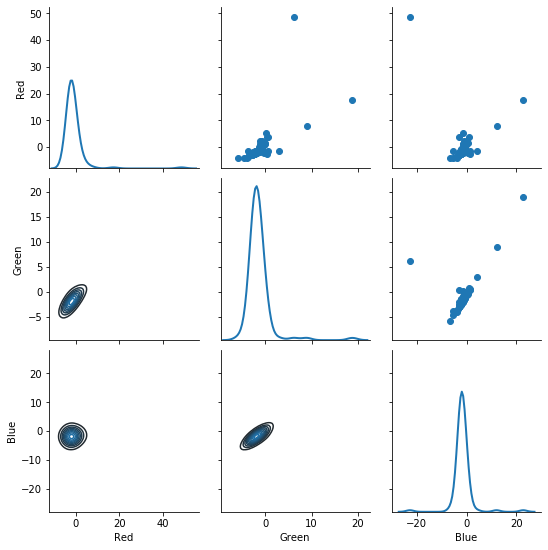

In [24]:
import numpy
import seaborn
import matplotlib.pylab
import pandas
cols = ['Red', 'Green', 'Blue']
data = pandas.DataFrame(inputs[0:100].detach().numpy(), columns = cols)
g = seaborn.PairGrid(data)
g.map_upper(matplotlib.pylab.scatter)
g.map_diag(seaborn.kdeplot, lw=2, legend=False);
g.map_lower(seaborn.kdeplot)
matplotlib.pylab.show()

In [38]:
back1, det = InverseFlow(NormalCdfFlow()).backward(outputs)
print(back1, det)
back2, det2 = SigmoidFlow().backward(back1)
print(back2, det2)

tensor([[0.3341, 0.9534, 0.7991],
        [0.6040, 0.5109, 0.6196],
        [0.2135, 0.5389, 0.5339],
        [0.2508, 0.8477, 0.6889],
        [0.6519, 0.9891, 0.5029],
        [0.9242, 0.1292, 0.0656],
        [0.7218, 0.2604, 0.5905],
        [0.6141, 0.0038, 0.7141],
        [0.3832, 0.9947, 0.2420],
        [0.8790, 0.3978, 0.1999],
        [0.8382, 0.1878, 0.9997],
        [0.0851, 0.0307, 0.2445],
        [0.8206, 0.6719, 0.0920],
        [0.9211, 0.2398, 0.1348],
        [0.4896, 0.1761, 0.9095],
        [0.4769, 0.8654, 0.8814],
        [0.9286, 0.1941, 0.8441],
        [0.5321, 0.3693, 0.5575],
        [0.6370, 0.2090, 0.7906],
        [0.2819, 0.9510, 0.5938],
        [0.4956, 0.2754, 0.5707],
        [0.7444, 0.3837, 0.5184],
        [0.4680, 0.4278, 0.8676],
        [0.6624, 0.4774, 0.5973],
        [0.8223, 0.6040, 0.9384],
        [0.3696, 0.4596, 0.6472],
        [0.6603, 0.4644, 0.9151],
        [0.6520, 0.3639, 0.2856],
        [0.6799, 0.4514, 0.1173],
        [0.985

In [47]:
vs, dets = cdf_flows.backward_trace(outputs)
print(vs)

85e-01],
        [ 3.0663e-01, -4.1562e-02, -7.7998e-02],
        [ 1.5309e-01, -6.0605e-02, -3.4924e-01],
        [-2.1258e-01, -3.1942e-01,  1.5403e-02],
        [ 2.7838e-01,  1.1939e-01,  3.6374e-01],
        [ 4.4399e-03, -2.4668e-01, -1.8654e-01]], grad_fn=<SqueezeBackward1>), tensor([[ 2.6169e-01, -8.5614e-01, -5.9120e-01],
        [ 1.0231e+00,  1.5548e-02, -1.1402e+00],
        [ 3.6486e-01, -5.9887e-01, -6.4663e-01],
        [ 6.8652e-01, -1.3379e-01, -9.4248e-01],
        [ 4.6117e-01, -5.0435e-01, -5.0649e-01],
        [ 6.4390e-02, -7.7022e-01, -6.1190e-01],
        [ 3.9923e-01, -5.1634e-01, -7.0015e-01],
        [-6.3661e-02, -9.0177e-01, -5.7212e-01],
        [-1.0870e+00,  1.7101e+00,  2.7803e+00],
        [ 1.3171e+00,  9.3217e-01, -1.3210e+00],
        [ 1.2455e+00, -4.2426e-01, -8.3997e-01],
        [ 8.5620e-02, -9.0476e-01, -7.5438e-01],
        [ 6.4677e-01, -6.8952e-01, -7.5213e-01],
        [ 1.7866e-01,  1.0416e+00,  5.9817e-01],
        [ 2.0328e-01, -6.5250e

In [26]:
print(list(net.parameters()))

[Parameter containing:
tensor([[ 1.0069, -0.4532, -0.3615],
        [ 0.0000,  1.2407,  0.0454],
        [ 0.0000,  0.0000,  1.0070]], requires_grad=True), Parameter containing:
tensor([ 0.3705,  0.5341, -0.1791], requires_grad=True), Parameter containing:
tensor([[ 0.9618,  0.0000,  0.0000],
        [-0.0733,  0.7338,  0.0000],
        [-0.9820, -1.0262,  1.0387]], requires_grad=True), Parameter containing:
tensor([ 0.1612, -0.3714, -0.2455], requires_grad=True), Parameter containing:
tensor([[ 1.4939,  1.3610, -0.2923],
        [ 0.0000,  2.0873,  0.4128],
        [ 0.0000,  0.0000,  2.2396]], requires_grad=True), Parameter containing:
tensor([0.8790, 2.1855, 0.3762], requires_grad=True), Parameter containing:
tensor([[ 2.5653,  0.0000,  0.0000],
        [-1.1119,  5.1261,  0.0000],
        [ 2.3548, -1.6615,  2.3564]], requires_grad=True), Parameter containing:
tensor([2.4744, 2.1065, 0.3810], requires_grad=True), Parameter containing:
tensor([[ 1.0923,  0.7685, -1.6083],
        [ 

In [45]:
print(outputs)

tensor([[ 2.4091, -0.3494, -0.3887],
        [ 1.1619,  0.5320,  0.7231],
        [-0.5120,  0.4510,  0.0136],
        [-1.4336, -1.4780, -0.3009],
        [-0.5058,  1.4605,  1.7551],
        [ 0.2955,  0.2532,  0.7358],
        [-1.8273,  2.3838,  0.1970],
        [-0.6831,  0.8884,  0.6336],
        [-0.6966,  1.7190, -1.2966],
        [-1.6591,  1.0530, -0.3500],
        [ 0.1557, -0.5943,  1.1341],
        [ 0.4915,  1.8369, -0.1893],
        [-0.3410,  0.0114, -1.0458],
        [-1.6320, -0.6535, -0.8757],
        [-0.6296, -0.8292, -0.4515],
        [-0.3534, -0.8078, -0.4259],
        [ 0.6561, -0.2979, -2.8213],
        [-1.1653,  2.6432, -0.6304],
        [ 0.3224,  0.0143, -0.8106],
        [-0.3273,  0.3960,  0.7803],
        [ 0.0524,  0.6845, -2.7882],
        [-2.0297, -0.2627,  1.4274],
        [ 0.0535, -1.4861, -0.1783],
        [ 1.0440,  0.6640, -1.0150],
        [ 1.4023,  0.2400,  1.6859],
        [-1.0035,  1.8550,  0.3414],
        [-0.6301, -0.8294, -0.2244],
 

In [49]:
print(data)

[tensor([[-0.3864, -0.6684, -0.0833],
        [-2.5205, -2.5205, -2.5205],
        [-1.1992, -0.7831, -0.5054],
        ...,
        [-2.8856, -2.8856, -2.3352],
        [-0.5054, -1.1992, -1.3539],
        [-1.9533, -1.6189, -1.3788]])]


In [48]:
print(cdf_flows.forward_trace(data[0]))

-6.1830e-01,  5.5547e+00,  6.9767e+00,  4.6447e+00,
         2.2618e+00,  1.3835e+00,  6.9767e+00,  4.3729e+00,  3.5290e+00,
         1.2301e+00,  3.3346e+00,  6.9767e+00,  3.7013e+00,  6.9767e+00,
         2.7158e+00,  1.8113e+00,  6.9767e+00,  2.2778e+00,  5.5547e+00,
        -2.8519e-01,  3.7464e+00,  6.9767e+00,  5.5547e+00,  2.8486e+00,
         2.9280e+00,  3.3568e+00,  2.1371e+00,  1.0955e+00,  3.8493e+00,
         3.3008e+00,  1.1259e+00,  5.5547e+00,  1.8994e+00,  6.9767e+00,
         2.7549e+00,  6.9767e+00, -3.3652e-01,  3.2914e+00,  3.4426e+00,
         1.4574e+00,  1.2419e+00,  6.9767e+00,  1.1970e+00,  3.5301e+00,
         5.5547e+00,  7.9663e-01,  2.9101e+00,  3.2853e+00,  1.3024e+00,
         6.9767e+00,  2.0231e+00,  2.9467e+00,  6.9767e+00,  4.9715e+00,
         2.5076e+00,  5.5547e+00, -6.7668e-01,  3.4659e+00,  2.9723e+00,
         4.7675e+00,  5.5547e+00,  4.0519e+00,  4.5033e+00,  2.9741e+00,
         2.9367e+00,  1.6515e+00,  6.9767e+00,  4.1575e+00,  1.5689e-02,